In [2]:
# Import required libraries
import os, sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
from tqdm.notebook import tqdm
from matplotlib.colors import LinearSegmentedColormap
# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory
from algorithms import GD, LogisticModel
from utils import set_randomness

In [3]:
def train_model(lr, races, y, yhat, order):
    n = len(races)
    d = 1
    model = LogisticModel(torch.zeros((d,)))
    optimizer = GD(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize tracking arrays
    thetas = torch.zeros(n+1, d, dtype=torch.float32)
    ys = torch.zeros(n+1, dtype=torch.float32)
    fs = torch.zeros(n+1, dtype=torch.float32)
    yhats = torch.zeros(n+1, dtype=torch.float32)
    losses = torch.zeros(n+1, dtype=torch.float32)
    gradients = torch.zeros(n+1, d, dtype=torch.float32)
    average_losses = torch.zeros(n+1, dtype=torch.float32)
    average_gradients = torch.zeros(n+1, d, dtype=torch.float32)
    race = [None]
    race_count = [0]
    
    model = model.to(device)
    loss_fn = nn.BCELoss()
    
    for t in range(n):
        races_t = races[t]
        y_t = y[t]
        f_t = yhat[t]
        r_t = ((y_t-f_t)+1)/2
        
        optimizer.zero_grad()
        thetas[t+1] = model.theta.detach().cpu()
        prediction = model(torch.ones(1).to(device))
        r_t = r_t.to(device)
        prediction.squeeze()
        loss = loss_fn(prediction, r_t)
        loss.backward()
        optimizer.step()
        
        race_idx = races_t.argmax().detach().cpu()
        ys[t+1] = y_t.detach().cpu()
        fs[t+1] = f_t
        yhats[t+1] = f_t + 2*prediction-1
        losses[t+1] = loss.detach().cpu().item()
        gradients[t+1] = model.theta.grad.detach().cpu()
        average_losses[t+1] = losses[:t+1].mean()
        average_gradients[t+1] = gradients[:t+1].mean(dim=0)
        thetas[t+1] = model.theta.detach().cpu()
        race += [order[race_idx]]
        race_count += [sum(np.array(race) == order[race_idx]) + 1]
    
    return pd.DataFrame({
        'theta': thetas.tolist(),
        'y': ys.tolist(),
        'f': fs.tolist(),
        'yhat': yhats.tolist(),
        'loss': losses.tolist(),
        'gradient': gradients.tolist(),
        'average_gradient': average_gradients.tolist(),
        'average_loss': average_losses.tolist(),
        'race': race,
        'race_count': race_count,
        'lr': lr
    })

In [4]:
# Cell for loading and preprocessing data
set_randomness(0)

# Load the COMPAS dataset
df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]
df['phat'] = df['v_decile_score']/10.0
df.compas_screening_date = pd.to_datetime(df.compas_screening_date)
df = df.sort_values(by='compas_screening_date')

# Prepare tensors
y = torch.tensor(df.is_recid.to_numpy()).float()
yhat = torch.tensor(df.phat.to_numpy()).float()
dummy_df = pd.get_dummies(df.race)
races = torch.tensor(dummy_df.values).float()
order = dummy_df.columns.values.tolist()
lrs = [0, 0.001, 0.01, 0.05]

In [5]:
results = []

for lr in tqdm(lrs, desc="Training models"):
    result_df = train_model(lr, races, y, yhat, order)
    results.append(result_df)

# Combine results
combined_df = pd.concat(results, ignore_index=True)
combined_df['norm of avg grad'] = combined_df['average_gradient'].apply(np.linalg.norm, ord=np.inf)

# Save results
os.makedirs('.cache/', exist_ok=True)
combined_df.to_pickle('.cache/debias.pkl')

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

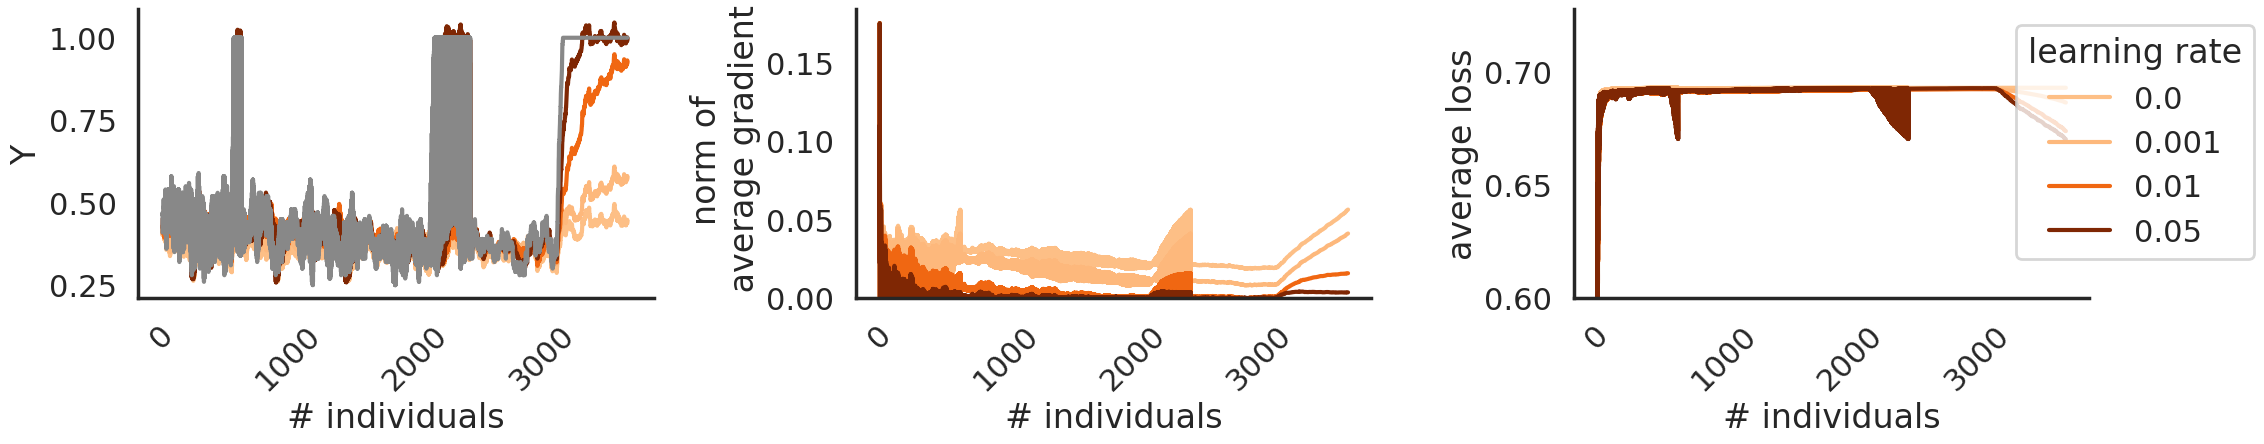

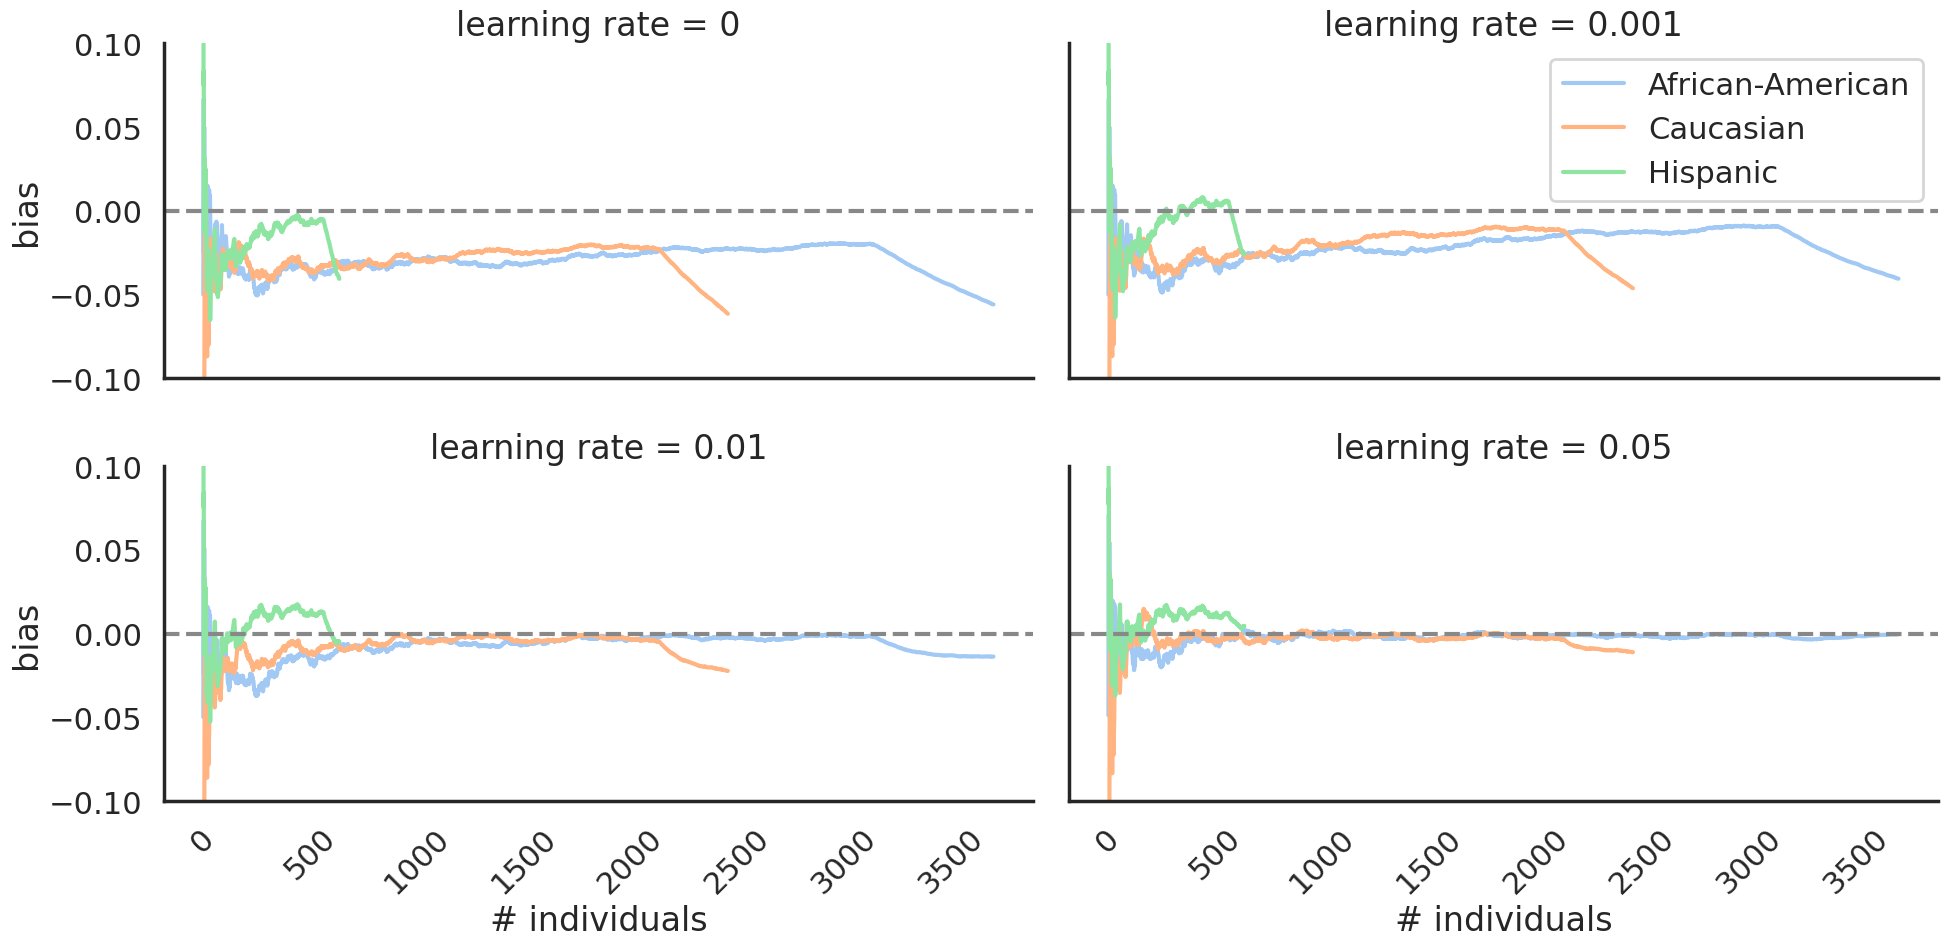

In [14]:
# Set styling
sns.set_style("white")
sns.set_context("poster")
sns.set_palette("pastel")

# Read from cache
combined_df = pd.read_pickle('.cache/debias.pkl')

# Create color map
lr_cmap_log = plt.colormaps["Oranges"]
lr_cmap = LinearSegmentedColormap.from_list(
    "Custom", 
    lr_cmap_log(np.logspace(-0.5, 1, 100, base=10))
)

# Plot 1: Time Series Analysis
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23,5), sharex=True, sharey=False)

# Get learning rates and create ordered lists
lr_values = sorted(combined_df['lr'].unique())
lr_values_reversed = sorted(combined_df['lr'].unique(), reverse=True)

# Define rolling window size
window_size = 100

# Left plot: Rolling average for predictions
# Predictions for each learning rate (plot these first)
pred_df = combined_df.copy()
pred_df['yhat_rolling'] = pred_df.groupby('lr')['yhat'].transform(
    lambda x: x.rolling(window=window_size, center=True).mean()
)
_lp = sns.lineplot(ax=axs[0], data=pred_df,
                  x="race_count", y="yhat_rolling",
                  hue="lr", palette=lr_cmap,
                  estimator=None, n_boot=0,
                  hue_order=lr_values)

# True values (plot these last so they appear on top)
true_df = combined_df[combined_df.lr == 0].copy()
true_df['y_rolling'] = true_df['y'].rolling(window=window_size, center=True).mean()
sns.lineplot(ax=axs[0], data=true_df,
            x="race_count", y="y_rolling", color="#888888",
            estimator=None, n_boot=0, label="True Values",
            zorder=10)  # Higher zorder ensures it's drawn on top

axs[0].set_ylabel("Y")
_lp.get_legend().remove()

# Middle plot: Gradient norm (unchanged)
_lp = sns.lineplot(ax=axs[1], data=combined_df, x="race_count",
                  y="norm of avg grad", hue="lr", palette=lr_cmap,
                  estimator=None, n_boot=0,
                  hue_order=lr_values_reversed)
axs[1].set_ylabel("norm of \n average gradient")
axs[1].set_ylim([0,None])
_lp.get_legend().remove()


# Right plot: Average loss (unchanged)
_lp = sns.lineplot(ax=axs[2], data=combined_df, x="race_count",
                  y="average_loss", hue="lr", palette=lr_cmap,
                  estimator=None, n_boot=0,
                  hue_order=lr_values_reversed)
axs[2].set_ylabel("average loss")
axs[2].set_ylim([0.6,None])
axs[2].legend(loc="upper right", bbox_to_anchor=(1.35,1), title='learning rate')


for ax in axs:
    ax.set_xlabel("# individuals")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('plots/debias/series.pdf')
plt.show()

# Plot 2: Bias Analysis (unchanged)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), 
                       sharey=True, sharex=True)
axs = axs.flatten()

for i, lr in enumerate(lrs):
    df_subset = combined_df[combined_df.lr == lr]
    for race_group in order:
        race_data = df_subset[df_subset.race == race_group]
        gradients = np.array(race_data.gradient.to_list())
        time = np.arange(len(gradients))+1
        average_gradient = gradients.cumsum(axis=0)/time[:,None]
        
        sns.lineplot(ax=axs[i], x=time, y=average_gradient[:,0], 
                    label=race_group, estimator=None, n_boot=0)
        if (i != 1):
            axs[i].get_legend().remove()
        
    axs[i].axhline(y=0, color='#888888', linestyle='--')
    axs[i].set_title(f'learning rate = {lr}')
    axs[i].set_xlabel("# individuals")
    if i % 2 == 0:
        axs[i].set_ylabel("bias")
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)

plt.ylim([-0.1, 0.1])
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('plots/debias/bias.pdf')
plt.show()

In [6]:
# Create indicators for each race category
indicators = [(combined_df[combined_df.lr == 0].race == o).astype(float) for o in order]

datetimes = df['compas_screening_date']

# Convert indicators to a DataFrame for easier manipulation
indicator_df = pd.DataFrame(np.column_stack(indicators)[1:], 
                          columns=order, 
                          index=datetimes)

# Calculate rolling means
rolling_means = indicator_df.rolling(window=window_size, min_periods=1).mean()

In [7]:
rolling_predictions = df[['phat', 'is_recid']].rolling(window=window_size, min_periods=1).mean()
rolling_bias = rolling_predictions['phat'] - rolling_predictions['is_recid']
df['rolling_bias'] = rolling_bias

/tmp/ipykernel_3432882/1801656636.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cal.set_xticklabels(ax_cal.get_xticklabels(), rotation=45)
/tmp/ipykernel_3432882/1801656636.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bias.set_xticklabels(ax_bias.get_xticklabels(), rotation=45)


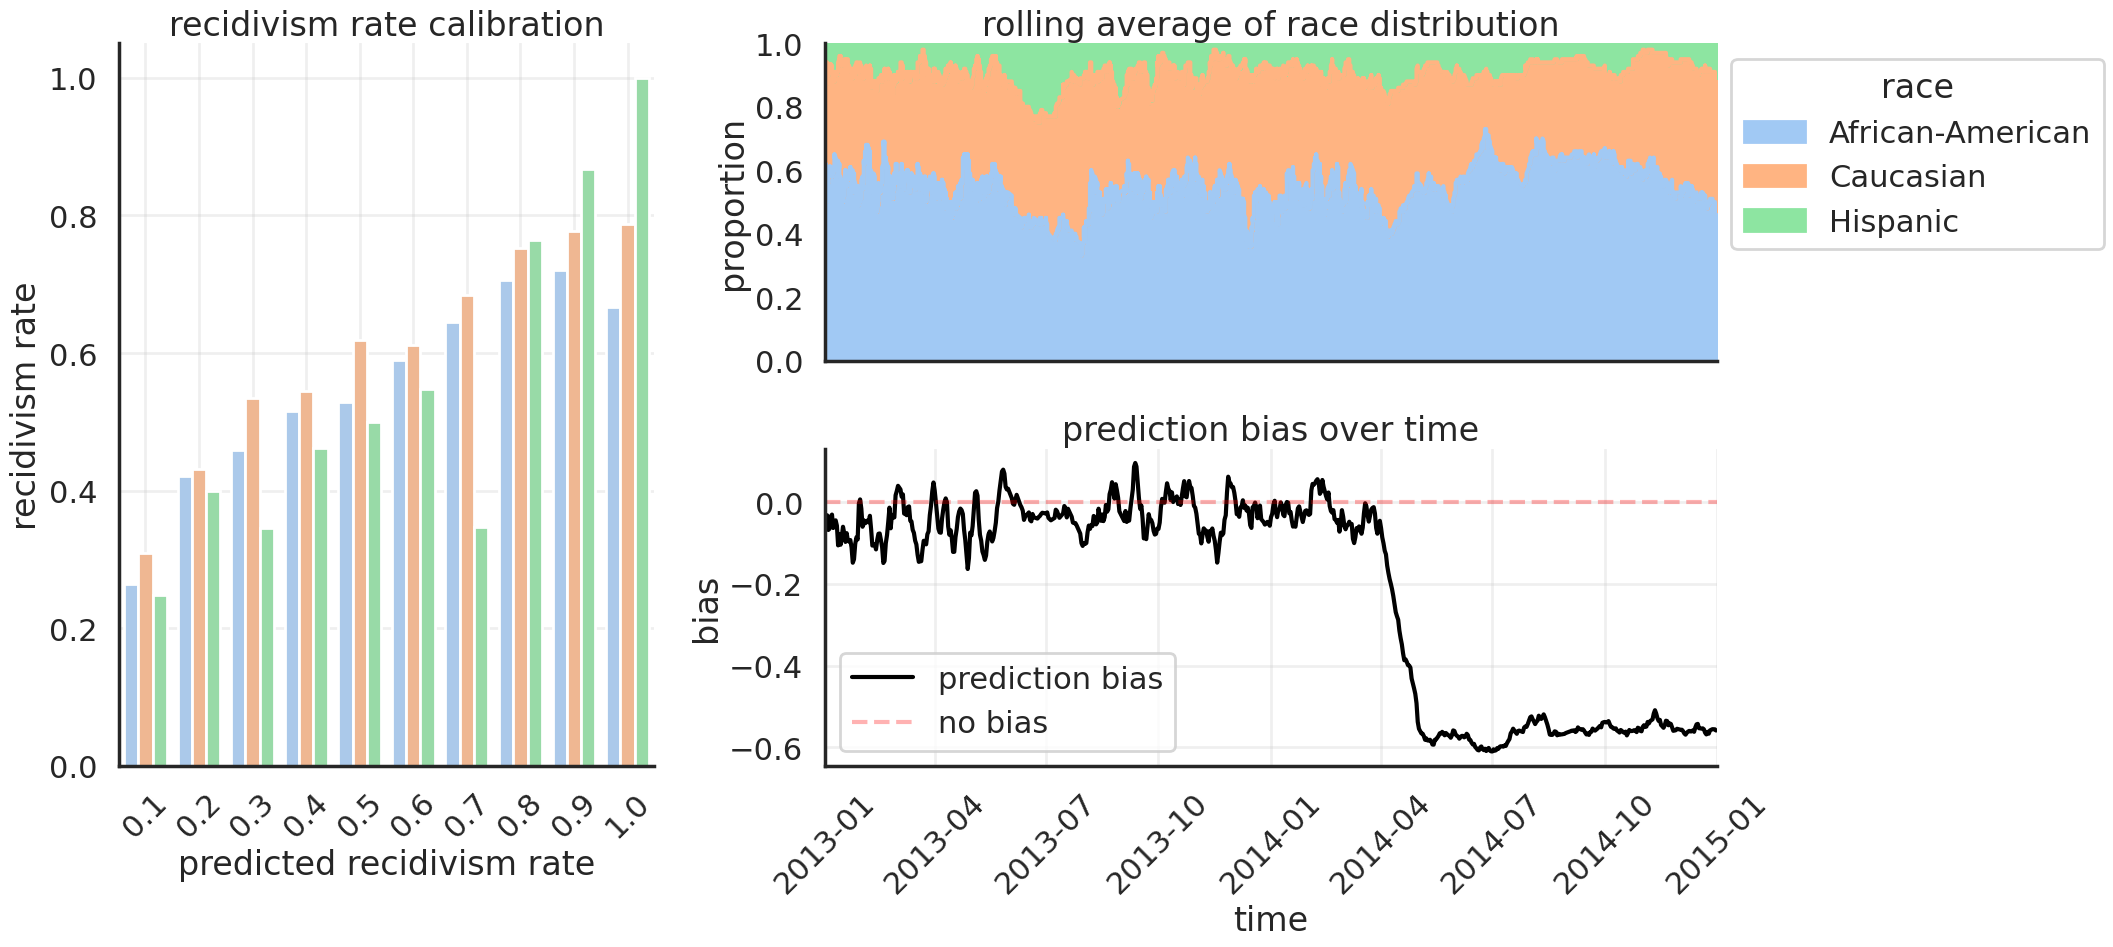

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Create figure with custom gridspec to handle the layout
fig = plt.figure(figsize=(22, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[1.5, 2.5], height_ratios=[1, 1])

# Calibration plot (left side, spans both rows)
ax_cal = fig.add_subplot(gs[:, 0])  # Takes full height of left column
sns.barplot(ax=ax_cal, data=df.round(1), x="phat", y="is_recid", hue="race", errorbar=None)
ax_cal.set_ylabel("recidivism rate")
ax_cal.set_xlabel("predicted recidivism rate")
ax_cal.set_xticklabels(ax_cal.get_xticklabels(), rotation=45)
ax_cal.set_title("recidivism rate calibration")
ax_cal.grid(alpha=0.3)
ax_cal.get_legend().remove()

# Race distribution plot (top right)
ax_race = fig.add_subplot(gs[0, 1])
rolling_means.plot(ax=ax_race, kind='area', stacked=True)
ax_race.set_title('rolling average of race distribution')
ax_race.set_xlabel('')  # Remove x-label since it's not the bottom plot
ax_race.set_ylabel('proportion')
ax_race.set_ylim([0, 1.0])
ax_race.set_xlim([datetime.date(2013, 1, 1), datetime.date(2015, 1, 1)])
ax_race.set_xticks([])
ax_race.set_xticklabels([])
ax_race.legend(title='race', bbox_to_anchor=(1.45, 1), loc='upper right')

# Bias over time plot (bottom right)
ax_bias = fig.add_subplot(gs[1, 1])
sns.lineplot(ax=ax_bias, data=df, x='compas_screening_date', y='rolling_bias', 
            label='prediction bias', color='k', errorbar=None)
ax_bias.axhline(y=0, color='r', linestyle='--', alpha=0.3, label='no bias')
ax_bias.set_title('prediction bias over time')
ax_bias.set_xlabel('time')
ax_bias.set_ylabel('bias')
ax_bias.legend()
ax_bias.grid(True, alpha=0.3)
ax_bias.margins(x=0.02)
ax_bias.set_xlim([datetime.date(2013, 1, 1), datetime.date(2015, 1, 1)])
ax_bias.set_xticklabels(ax_bias.get_xticklabels(), rotation=45)

# General styling
sns.despine(fig=fig, top=True, right=True)
plt.tight_layout()

# Save and show the plot
plt.savefig('./plots/debias/compas_statistics.pdf')
plt.show()